# Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
"""
Change directory to where this file is located
"""
%cd '/content/drive/My Drive/Colab Notebooks/MLDL1_HW4'

/content/drive/My Drive/Colab Notebooks/MLDL1_HW4


In [3]:
import math
import random
from pathlib import Path
import sys

from data.data import prepareData

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer
from torch.utils.data import Dataset, DataLoader, random_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
"""
import modules you need
"""


'\nimport modules you need\n'

## Util

**Do NOT Modify** code blocks in this section

In [5]:
SEED = 1234
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True

In [6]:
def train(model, iterator, optimizer, loss_fn, clip):
    model.train()
    epoch_loss = 0

    for i, batch in enumerate(iterator):
        src = batch[0].to(DEVICE)
        trg = batch[1].to(DEVICE)
        optimizer.zero_grad()
        output = model(src, trg)
        loss = loss_fn(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [7]:
def evaluate(model, iterator, loss_fn):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src = batch[0].to(DEVICE)
            trg = batch[1].to(DEVICE)
            output = model(src, trg)
            loss = loss_fn(output, trg)
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [8]:
def plot_history(history):
    plt.figure(figsize=(2 * 13, 4))
    plt.subplot(1, 5, 1)
    plt.title("Training and Validation Loss")
    plt.plot(history['train_PPL'], label="train_PPL")
    plt.plot(history['val_PPL'], label="val_PPL")
    plt.xlabel("iterations")
    plt.ylabel("PPL")
    plt.legend()
    plt.subplot(1, 5, 2)
    plt.title("Learning Rate")
    plt.plot(history['lr'], label="learning rate")
    plt.xlabel("iterations")
    plt.ylabel("LR")
    plt.show()

## Dataset & Dataloader

**Do NOT Modify** code blocks in this section

In [9]:
MAX_LENGTH = 10
BATCH_SIZE = 64

TRAIN_RATIO = 0.7 # train dataset ratio, should be a float in (0, 0.8]
VALID_RATIO = 0.8 - TRAIN_RATIO

SOS_token = 0
EOS_token = 1

In [10]:
class TranslateDataset(Dataset):
    def __init__(self, max_length=10, fra2eng=True):
        self.input_lang, self.output_lang, self.pairs = prepareData('eng', 'fra', max_length=max_length, reverse=fra2eng)
        self.max_length = max_length
        self.input_lang.addWord('PAD')
        self.output_lang.addWord('PAD')
        self.input_lang_pad = self.input_lang.word2index['PAD']
        self.output_lang_pad = self.output_lang.word2index['PAD']

        print("\n")
        print("This is data example")
        print(random.choice(self.pairs))

        print("\n")
        print("This is index of PAD token for each language")
        print(f"fra {self.output_lang.word2index['PAD']}")
        print(f"eng {self.input_lang.word2index['PAD']}")

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        pair = self.pairs[idx]
        x, y = self._tensorsFromPair(pair)
        return x, y

    def _tensorFromSentence(self, lang, sentence):
        indexes = [lang.word2index[word] for word in sentence.split(' ')]
        indexes.append(EOS_token)
        return torch.tensor(indexes, dtype=torch.long).view(-1, 1)

    def _tensorsFromPair(self, pair):
        input_tensor = self._tensorFromSentence(self.input_lang, pair[0])
        target_tensor = self._tensorFromSentence(self.output_lang, pair[1])
        return (input_tensor, target_tensor)

    def collate_fn(self, data):
        x_batch = []; y_batch = []

        for x, y in data:
            if x.shape[0] < self.max_length-1:
                x = torch.cat([x, self.input_lang_pad*torch.ones((self.max_length-1 - x.shape[0], 1), dtype=x.dtype)])
            elif x.shape[0] > self.max_length-1:
                x = x[:self.max_length-1]
            if y.shape[0] < self.max_length-1:
                y = torch.cat([y, self.output_lang_pad*torch.ones((self.max_length-1 - y.shape[0], 1), dtype=y.dtype)])
            elif y.shape[0] > self.max_length-1:
                y = y[:self.max_length-1]

            x_batch.append(torch.cat([torch.tensor([SOS_token]), x.squeeze(1)]))
            y_batch.append(torch.cat([torch.tensor([SOS_token]), y.squeeze(1)]))

        return torch.stack(x_batch), torch.stack(y_batch)

dataset = TranslateDataset(max_length=MAX_LENGTH)

train_size = int(len(dataset)*TRAIN_RATIO)
valid_size = int(len(dataset)*VALID_RATIO)
train_data, valid_data, test_data = random_split(dataset, [train_size, valid_size, len(dataset)-(train_size+valid_size)],)
print("\n")
print(f"This is dataset_size: {len(dataset)}")
print(f"train_size: {train_size}")
print(f"valid_data: {valid_size}")
print(f"test_data: {len(test_data)}")

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=dataset.collate_fn, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=BATCH_SIZE, collate_fn=dataset.collate_fn, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, collate_fn=dataset.collate_fn, shuffle=True)

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803


This is data example
['tu me fais de l ombre .', 'you re blocking my light .']


This is index of PAD token for each language
fra 2803
eng 4345


This is dataset_size: 10599
train_size: 7419
valid_data: 1059
test_data: 2121


## Implement LSTM Seq2Seq Model

In [18]:
class LSTMEncoder(nn.Module):

    def __init__(self, in_dim, emb_dim, hid_dim):
        super(LSTMEncoder, self).__init__()

        self.embedding = nn.Embedding(in_dim, emb_dim)
        self.lstm = nn.LSTM(input_size=emb_dim, hidden_size=hid_dim, num_layers=1, batch_first=True)

    def forward(self, input, hidden, cell):
        '''
        Q2 - (a)
        Implement forward method of LSTM Encoder Module

        INPUT
        - input: input sentence, (B, max_len)
        - hidden: initialized hidden state, (1, B, hid_dim)
        - cell: initialized cell state, (1, B, hid_dim)

        OUTPUT
        What to be returned depends on your implementation of LSTMSeq2Seq. (Q2 - (b))
        Feel free to return outputs you need. (e.g. hidden states of encoder, etc.)
        '''

        embedded = self.embedding(input)  # Shape: (B, max_len, emb_dim)

        # Passing through the LSTM layer
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))  # output: (B, max_len, hid_dim), hidden, cell: (1, B, hid_dim)

        # Return the outputs required by the LSTMSeq2Seq model
        return output, hidden, cell

In [26]:
class AttnLSTMDecoder(nn.Module):

    def __init__(self, emb_dim, hid_dim, out_dim, dropout, enc_hiddens=None):
        super(AttnLSTMDecoder, self).__init__()
        self.enc_hiddens = enc_hiddens # encoder output
        self.dropout = dropout
        self.t = 0

        self.embedding = nn.Embedding(out_dim, emb_dim)
        self.lstm = nn.LSTM(input_size=emb_dim, hidden_size=hid_dim, batch_first=True)
        self.fc = nn.Linear(hid_dim + hid_dim, hid_dim)
        self.tanh = nn.Tanh()
        self.classifier = nn.Linear(hid_dim, out_dim)

    def forward(self, input, hidden, cell):

        '''
        Q2 - (a)
        Implement forward method of LSTM Decoder Module with dot-product attention
        Before implementing LSTM layer, make sure to feed the concatenated input into Linear and tanh activation layer.
        This will allow the concatenated input to be resized from (B, hid_dim + hid_dim) into (B, hid_dim)

        INPUT
        - input: a token of input sentence (B, 1)
        - hidden: previous hidden state (B, hid_dim)
        - cell: previous cell state (1, B, hid_dim)

        OUTPUT
        What to be returned depends on your implementation of LSTMSeq2Seq. (Q2 - (b))
        Feel free to return outputs you need.
        Some examples below
        - predicted token embedding (N, emb_dim)
        - current hidden state
        - current cell state
        '''

        embedded = self.embedding(input)  # Shape: (B, 1, emb_dim)

        query = hidden.squeeze(0) # shape: (B, hid_dim, 1)

        # Calculate attention weights
        keys = self.enc_hiddens # encoder output, shape: (B, seq_len, hid_dim)
        values = self.enc_hiddens

        attn_weights = torch.bmm(keys, query.unsqueeze(2))
        attn_weights = attn_weights.squeeze(2)  # Shape: (B, seq_len)
        attn_weights = F.softmax(attn_weights, dim=1)

        # Compute context vector
        attn_values = torch.bmm(attn_weights.unsqueeze(1), values)  # Shape: (B, 1, hid_dim)
        attn_values = attn_values.squeeze(1) # Shape: (B, hid_dim)

        # Concatenate and process
        lstm_input = torch.cat((embedded.squeeze(1), attn_values), dim=1)  # Shape: (B, 1, emb_dim + hid_dim)
        #processed_input = self.tanh(self.fc(concatenated))  # Shape: (B, hid_dim)

        lstm_input = self.tanh(self.fc(lstm_input)) # Shape: (B, hid_dim)
        lstm_input = lstm_input.unsqueeze(1) # Shape: (B, 1, hid_dim)

        output, (hidden, cell) = self.lstm(lstm_input, (hidden, cell))  # hidden and cell are (1, B, hid_dim)

        # Pass the output through the classifier to generate the final output
        prediction = self.classifier(output.squeeze(1))  # (B, out_dim)

        return prediction, hidden, cell

        # # LSTM layer
        # output, (hidden, cell) = self.lstm(concatenated, (hidden.unsqueeze(0), cell))
        # output = output.transpose(0,1)

        # # Classifier
        # prediction = self.classifier(output[0])  # Shape: (B, out_dim)
        # log_softmax = nn.LogSoftmax(dim=1)
        # prediction = log_softmax(prediction)

        # self.t += 1

        # return prediction, hidden.squeeze(0), cell

In [32]:
class LSTMSeq2Seq(nn.Module):
    def __init__(self, in_dim, out_dim, emb_dim, hid_dim, device, dropout):
        super(LSTMSeq2Seq, self).__init__()

        self.in_dim = in_dim
        self.out_dim = out_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.device = device
        self.dropout = nn.Dropout(dropout)

        self.encoder = LSTMEncoder(in_dim, emb_dim, hid_dim)
        self.decoder = AttnLSTMDecoder(emb_dim, hid_dim, out_dim, dropout)

    def forward(self, src, trg):
        '''
        Q2 - (b)
        Implement forward method of LSTM Seq2Seq Module
        (Decoder module should attend encoder's outputs using dot product.)

        INPUT
        - src: source language batched data (B, max_len)
        - trg: target language batched data (B, max_len)

        OUTPUT
        - output of one-hot prediction (B, out_dim, max_len)
        '''

        batch_size, max_len = src.shape

        # Hidden and cell states
        hidden = torch.zeros(1, batch_size, self.hid_dim).to(self.device)
        cell = torch.zeros(1, batch_size, self.hid_dim).to(self.device)

        # Encoder
        encoder_outputs, hidden, cell = self.encoder(src, hidden, cell)

        # Decoder: pass the encoder's outputs to the decoder
        self.decoder.enc_hiddens = encoder_outputs

        # Prepare the output tensor
        outputs = torch.zeros(batch_size, max_len, self.out_dim).to(self.device)

        input = trg[:, 0] # input to dec

        for t in range(0, max_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[:, t, :] = output

            max = output.argmax(1)
            input = max

        return outputs.permute(0, 2, 1) # Shape: (B, out_dim, max_len)

## Training

In [33]:
'''
Q2 - (c)
Train your Seq2Seq model and plot perplexities and learning rates.
Upon successful training, the test perplexity should be less than 7.
Briefly report your hyperparameters and results on test dataset.
Make sure your results are printed in your submitted file.
'''

'\nQ2 - (c)\nTrain your Seq2Seq model and plot perplexities and learning rates.\nUpon successful training, the test perplexity should be less than 7.\nBriefly report your hyperparameters and results on test dataset.\nMake sure your results are printed in your submitted file.\n'

In [34]:
# experiment various methods for better performance
# you can modify the codes in this block
in_dim = dataset.input_lang.n_words
out_dim = dataset.output_lang.n_words
hid_dim = 512
emb_dim = 512
dropout = 0.1
learning_rate = 0.001
N_EPOCHS = 20
valid_every= 3
best_valid_loss = float('inf')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMSeq2Seq(in_dim, out_dim, emb_dim, hid_dim, device, dropout).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss(ignore_index = dataset.output_lang_pad)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=5, verbose=True)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.85)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.1, step_size=10)


# lr = 0.005, (adam) weight_decay = 0.85, gamma = 0.85, epochs = 60, valid_every = 5


Epoch: 01
	Train Loss: 3.246 | Train PPL:  25.687
	 Val. Loss: 2.563 |  Val. PPL:  12.969
Epoch: 02
	Train Loss: 2.359 | Train PPL:  10.580
Epoch: 03
	Train Loss: 2.075 | Train PPL:   7.968
Epoch: 04
	Train Loss: 1.847 | Train PPL:   6.341
	 Val. Loss: 2.035 |  Val. PPL:   7.649
Epoch: 05
	Train Loss: 1.632 | Train PPL:   5.113
Epoch: 06
	Train Loss: 1.435 | Train PPL:   4.198
Epoch: 07
	Train Loss: 1.245 | Train PPL:   3.472
	 Val. Loss: 1.793 |  Val. PPL:   6.006
Epoch: 08
	Train Loss: 1.075 | Train PPL:   2.929
Epoch: 09
	Train Loss: 0.922 | Train PPL:   2.514
Epoch: 10
	Train Loss: 0.776 | Train PPL:   2.172
	 Val. Loss: 1.652 |  Val. PPL:   5.217
Epoch: 11
	Train Loss: 0.648 | Train PPL:   1.912
Epoch: 12
	Train Loss: 0.535 | Train PPL:   1.707
Epoch: 13
	Train Loss: 0.434 | Train PPL:   1.544
	 Val. Loss: 1.620 |  Val. PPL:   5.053
Epoch: 14
	Train Loss: 0.347 | Train PPL:   1.415
Epoch: 15
	Train Loss: 0.283 | Train PPL:   1.327
Epoch: 16
	Train Loss: 0.238 | Train PPL:   1.269


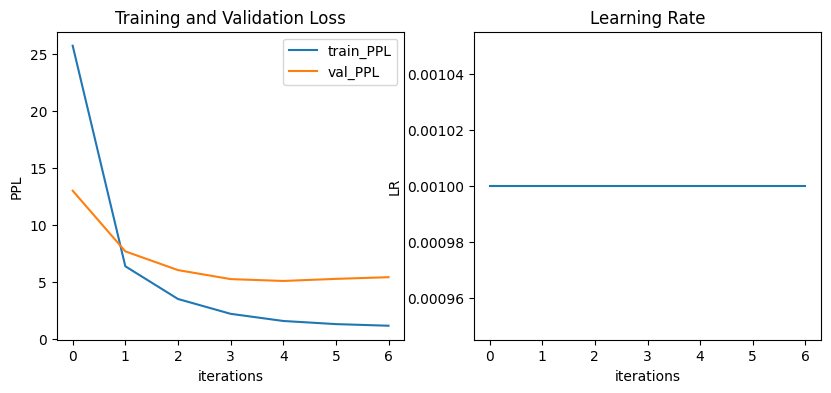

In [35]:
# Train your model

history = {'train_PPL':[], 'val_PPL':[], 'lr':[]}

for epoch in range(N_EPOCHS):
    train_loss = train(model, train_dataloader, optimizer, loss_fn, 1)

    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')

    if epoch%valid_every==0:
        print("==========================")
        valid_loss = evaluate(model, valid_dataloader, loss_fn)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            model.decoder.t=0
            torch.save(model.state_dict(), 'lstm-attn-model.pt')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

        #scheduler.step()

        history['train_PPL'].append(math.exp(train_loss))
        history['val_PPL'].append(math.exp(valid_loss))
        history['lr'].append(optimizer.param_groups[0]['lr'])

plot_history(history)

In [36]:
# Test your model
torch.save(model.state_dict(), 'lstm-attn-model.pt')
loaded_model = LSTMSeq2Seq(in_dim, out_dim, emb_dim, hid_dim, device, dropout).to(device)
loaded_model.load_state_dict(torch.load('lstm-attn-model.pt'))

test_loss = evaluate(loaded_model, test_dataloader, loss_fn)
print(f'\t Test. Loss: {valid_loss:.3f} |  Test. PPL: {math.exp(valid_loss):7.3f}')

	 Test. Loss: 1.683 |  Test. PPL:   5.384


Briefly report your hyperparameters and results on test datasets.  

You Answer : The hyperparameters were set by doing experiments on various combinations. At the first try, the model seemed to be overfitting to the training data, implied by the huge gap of PPL between train PPL and val PPL. Therefore, adjustments of hidden_dim, learning_rate were conducted.  Also, the number of epochs seems to contribute to the result since increasing the number of epochs over 20 seemed to rather increase the validation and eval ppl. Therefore, the optimal number was set at 20.